# keras中的构件

# keras中的数据操作

# keras中的模型对象

keras中的模型对象具备多个特性（properties）和方法供用户使用，包括但不限于获取模型的结构，获取每层的参数及其特性，获取每层的名字等。这些特性和方法给建模者提供了高度灵活的方法来获取模型的某一特定部分的信息，既可用于模型的可视化（稍后介绍），也可用于模型的定制和生成过程。这些操作包括：

- 抽取特定模型层
- 抽取各层的权重和名称
- 定义各层是否可以被新数据训练
- 使用后台函数对各层的输入输出进行定制计算等

我们下面来针对以上操作讲解一下。

### 抽取模型层
keras的模型包含多个属性可以进行引用。假设我们已经有了一个模型，被称为model，这个模型不一定需要被训练，因为在编译模型的时候，每一层的权重都会根据一个随机函数进行初始化，因此一个没有训练的模型和一个已经训练过的模型的主要差异在于参数是否根据训练样本优化过。这里我们暂时不详细讨论初始化的细节。

model里可以抽取以下各个子对象：
- model.layers。该可迭代对象输出模型的各个网络层及其包含的元素，比如参数值，网络层名字等。
- model.trainable_weights。该对象返回模型层里可以被训练的参数列表。因为在上面提到的返回的各个模型层包含该层被定义为是否可以被训练的特性，如果是的话，则在引用该对象的时候可以被返回。
- model.weights。该对象返回模型的参数。

下面一节我们通过一个使用keras展示激活函数几何特性的方式来学习这些操作。

神经网络之所以强大，与其采用非线性的激活函数不无关系。在这里，我们试图通过运用keras来展示和分析激活函数从而让同学们同时了解keras的一些奇妙用法。

1. 首先，我们采用keras来生成不同激活函数的表达，并以图形的形式展示出来。
2. 然后，我们通过分析keras的源代码来演示如何生成自己自定义的激活函数。

In [95]:
%matplotlib inline

import pandas as pd
import numpy as np
import gc
from keras.layers import Dense, Activation
from keras.models import Sequential

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16, 10)
# 以下设置显示正文方法根据 http://blog.csdn.net/rumswell/article/details/6544377 
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体  
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题  

这里我们先定义一个简单的神经网络模型，该模型由一个输入层，一个全连接隐含层和一个输出层构成。待考察的激活函数就在全连接隐含层中定义，输出层只定义一个线性激活函数，这样在后面可视化的时候我们看到的数据形态就完全有全连接隐含层中的激活函数来形成。出于简化考虑，我们的输入变量只考虑了一个向量。

In [86]:
x = (np.arange(200)-100)/100
y = -np.log(x+101/100)

model = Sequential()
model.add(Dense(1, input_shape=(1,), activation='relu', name='Hidden'))
model.add(Dense(1, activation='linear', name='Output'))
model.summary()
model.compile(loss='mse', optimizer='adam')
#model.fit(x, x, epochs=3, batch_size=128, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden (Dense)               (None, 1)                 2         
_________________________________________________________________
Output (Dense)               (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


现在我们已经定义了一个模型了，并且该模型已经根据输入的训练数据进行了优化。为了演示激活函数的几何表现，我们需要抓取全连接隐含层的输出。

In [87]:
from keras import backend as K

inp = model.input                                           # 输入
outputs = [layer.output for layer in model.layers if layer.name=='Hidden']          # 抓取所需网络层，实际这里最关键的只有激活层
#outputs = [layer.output for layer in model.layers]
functions = [K.function([inp], [out]) for out in outputs]    # K.function()使用tenforflow后台初始化一个计算函数

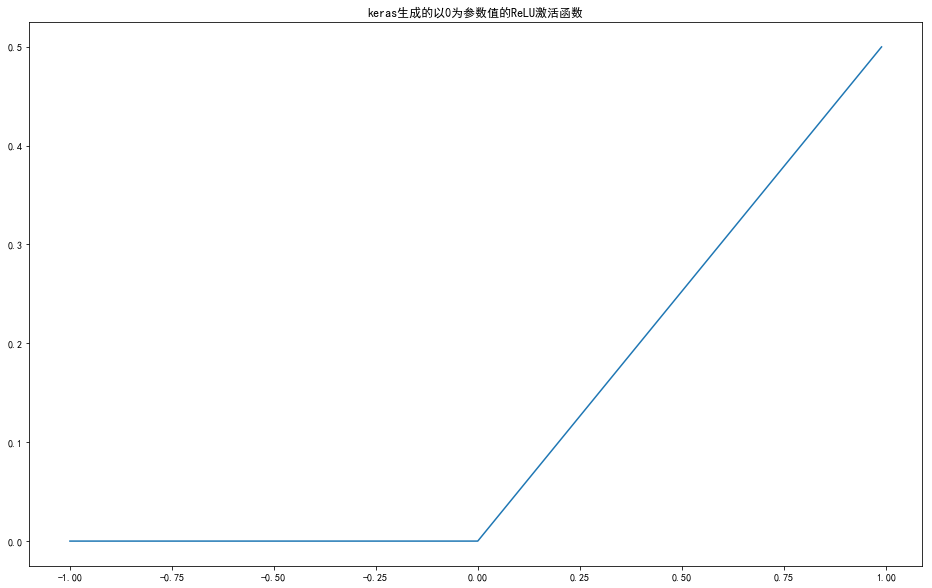

In [96]:
# 验证结果

layer_outs = [func([x.reshape(-1, 1)]) for func in functions]
activationLayer = layer_outs[0][0]
    
activationDf = pd.DataFrame(activationLayer)
plt.plot(x, activationDf)   
plt.title(u'keras生成的以0为参数值的ReLU激活函数')
plt.show()

In [62]:
activationLayer

0.0

In [99]:
def NNmodel(activationFunc='linear'):
    '''
       定义一个神经网络模型。如果要定义不同的模型，可以直接修改该函数
    '''
    model = Sequential()
    model.add(Dense(1, input_shape=(1,), activation=activationFunc, 
                    kernel_initializer='he_uniform', 
                    name='Hidden'))
        
    model.add(Dense(1, activation='linear', name='Output'))   
    model.compile(loss='mse', optimizer='sgd')
    return model

def VisualActivation(activationFunc='relu', plot=True):    
    x = (np.arange(100)-50)/10
    y = np.log(x+x.max()+1)
    
    model = NNmodel(activationFunc = activationFunc)
    
    inX = model.input                                          
    outputs = [layer.output for layer in model.layers if layer.name=='Hidden']     
    functions = [K.function([inX], [out]) for out in outputs]   
    
    layer_outs = [func([x.reshape(-1, 1)]) for func in functions]
    activationLayer = layer_outs[0][0]
        
    activationDf = pd.DataFrame(activationLayer)
    result=pd.concat([pd.DataFrame(x), activationDf], axis=1)
    result.columns=['X', 'Activated']
    result.set_index('X', inplace=True)
    if plot:
        result.plot(title=f)
    
    return result

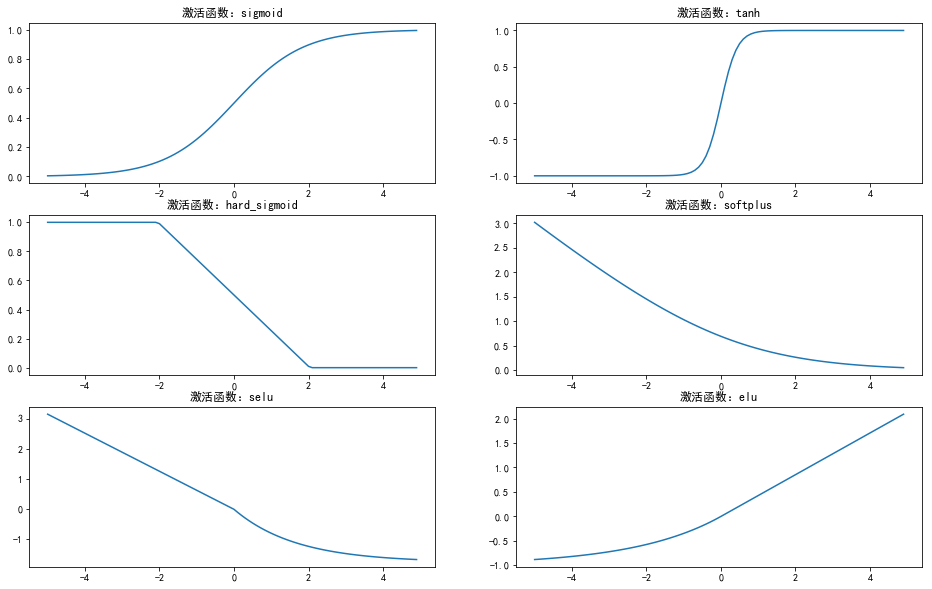

In [100]:
actFuncs = ['sigmoid', 'tanh', 'hard_sigmoid', 'softplus', 'selu', 'elu']

from keras.layers import LeakyReLU
figure = plt.figure()
for i, f in enumerate(actFuncs):
    # 依次画图
    figure.add_subplot(3, 2, i+1)
    out=VisualActivation(activationFunc=f, plot=False)
    plt.plot(out.index, out.Activated)
    plt.title(u'激活函数：'+f)

从上面的操作我们可以学习到以下知识点：
1. 一个模型就是一个对象，其包含多个属性可供分析师抽取，进行进一步的分析和操作，比如抽取权重画图；
2. 可以通过后台函数K.function()来定义对输入数据在每一层进行计算，从而可以进一步分析每一步的运算特性；
3. 中间层计算结果输出是一个列表，因此非常容易查看输出的结构，并进行相应的操作；

# keras中的优化引擎

本节介绍keras中的不同优化引擎的行为特点，特别是使用图示的方法形象地展示不同优化引擎在不同的损失函数曲面上的求解路径。

下面的图分别展示了不同优化引擎的算法。可以看到，新的优化引擎主要是在momentum和gradient计算点上做文章。

![SGD](./images/optimizers/SGD.PNG)

![SGDmomentum](./images/optimizers/SGDmomentum.PNG)

![SGDnesterov](./images/optimizers/SGDnesterov.PNG)

![AdaGrad](./images/optimizers/ADaGrad.PNG)

![RMSprop](./images/optimizers/RMSprop.PNG)

![Adam](./images/optimizers/Adam.PNG)

## 演示不同求解引擎的参数求解路径

这里我们的主要目的是考察不同损失函数的空间曲面以及参数在不同优化引擎下的的求解路径。与此同时我们可以学习到keras模型类对象自带的特性和方法，并灵活运用。

处于简化的目的，我们首先只根据MNIST数据集训练一个逻辑斯特回归（logistic regression）的分类器，然后考察其中任意两个参数在不同优化引擎下的表现。为此我们需要先将MNIST数据通过奇异值分解（SVD）投影到一个2维空间，再构造一个logistic regression。

然后我们会进行延伸，主要是将待分析模型扩展到任意神经网络模型中，并让读者可以任意选取两个参数进行可视化。任意网络模型也可以更好地体现不同优化引擎的特性，因为毕竟logistic regression优化的是一个有较好特性的凸函数（最大似然函数）。

下面我们先导入需要的库。

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import h5py
import keras
import keras.backend as K

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import animation

plt.rcParams['figure.figsize']=(16,12)

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0],28*28).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28*28).astype('float32')
X_train /= 255
X_test /= 255

target = to_categorical(y_train)

In [3]:
X_train.shape

(60000, 784)

In [4]:
u,s,v = np.linalg.svd(X_train, full_matrices=False)

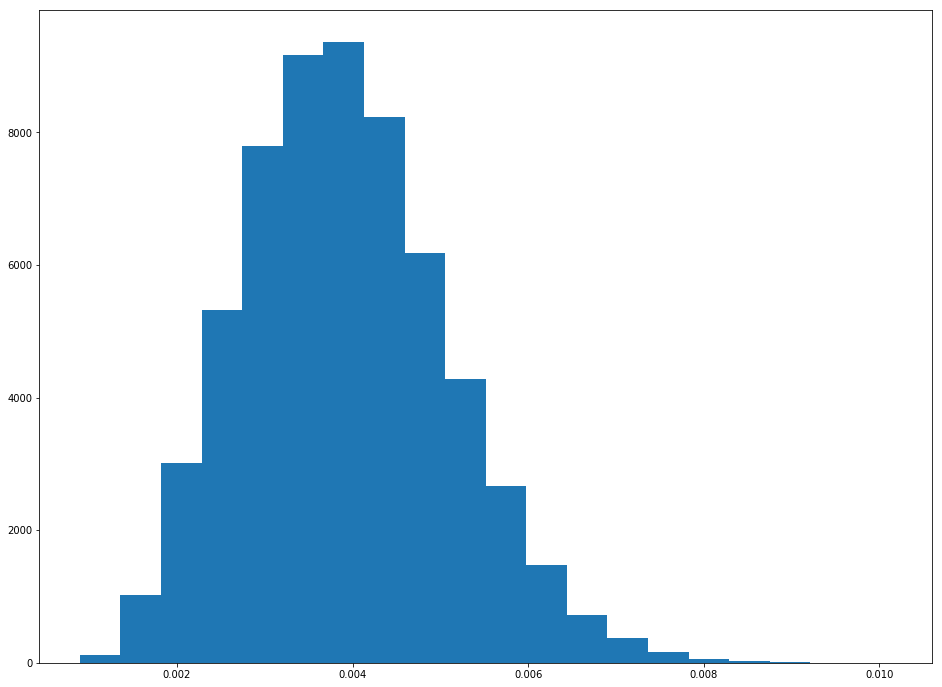

In [5]:
plt.hist(u[:, 0], bins=20)
plt.show()

In [17]:
# Now build a MLP based on first 2 eigenvectors
u2 = u[:,:2]

def GetModel(lossfunction='categorical_crossentropy', optimizer='adam'):
    model = Sequential()
    #model.add(Dense(2, activation='relu', input_shape=(2,), name='Hidden0'))
    #model.add(Dense(2, activation='relu', name='Hidden1'))
    model.add(Dense(1, input_shape=(2,), activation='linear', name='Output'))
    model.summary()
    model.compile(loss=lossfunction, optimizer=optimizer, metrics=['accuracy'])
    return model

model=GetModel(lossfunction='mse', optimizer='sgd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Output (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Now fit the model
wgtsfile='./data/EstimationHistory_{epoch:02d}.h5'
checkpoint = ModelCheckpoint(wgtsfile, monitor='loss', 
                             verbose=0, save_best_only=False, save_weights_only=False, 
                             mode='auto', period=1)
%time model.fit(u2, y_train, batch_size=1024, epochs=50, verbose=0, callbacks=[checkpoint])

Wall time: 10.6 s


In [96]:
%%time
# load the checkpoint file to see what's inside
from keras.models import load_model
modelwgt = load_model('./data/EstimationHistory_' + str(49).zfill(2) + '.h5', compile=False)

Wall time: 297 ms


In [97]:
print(modelwgt.get_weights())

[array([[-1.19792819],
       [-0.1732402 ]], dtype=float32), array([ 4.46082878], dtype=float32)]


In [36]:
count = 0
for layer in modelwgt.layers:
    count += 1
    name = layer.name
    weights = layer.get_weights() # list of numpy arrays
    print(name, weights)

Output [array([[-1.22623456],
       [-0.04644569]], dtype=float32), array([ 4.45904255], dtype=float32)]


In [44]:
weights[0].reshape(-1, 2)[0]

array([-1.22623456, -0.04644569], dtype=float32)

In [23]:
hidden1=modelwgt.get_layer(name='Output')
wgt=hidden1.get_weights()
print(len(wgt[0].shape))

2


In [45]:
%%time

def loadwgts(wgtfile, layerName):
    model = load_model(wgtfile, compile=False)
    layer = model.get_layer(name=layerName)
    wgts = layer.get_weights()
    if len(wgts[0].shape)==1:
        return wgts[0]
    else:
        return wgts[0].reshape(-1, 2)[0]

allwgts = {}
for i in range(50):
    filename='./data/EstimationHistory_' + str(i+1).zfill(2) + '.h5'    
    allwgts[i] = loadwgts(filename, 'Output')
    #print(filename)

Wall time: 13.8 s


In [46]:
allwgts

{0: array([-1.23472607, -0.01240659], dtype=float32),
 1: array([-1.23073339, -0.01613562], dtype=float32),
 2: array([-1.22929049, -0.01960747], dtype=float32),
 3: array([-1.22863615, -0.02298831], dtype=float32),
 4: array([-1.22821033, -0.02633735], dtype=float32),
 5: array([-1.22784889, -0.02968689], dtype=float32),
 6: array([-1.22751641, -0.03304135], dtype=float32),
 7: array([-1.22721219, -0.03638439], dtype=float32),
 8: array([-1.22688925, -0.03974401], dtype=float32),
 9: array([-1.22656441, -0.04309757], dtype=float32),
 10: array([-1.22623456, -0.04644569], dtype=float32),
 11: array([-1.22592139, -0.04980237], dtype=float32),
 12: array([-1.22558832, -0.0531592 ], dtype=float32),
 13: array([-1.22526348, -0.05651024], dtype=float32),
 14: array([-1.22494602, -0.05985571], dtype=float32),
 15: array([-1.22463846, -0.06320609], dtype=float32),
 16: array([-1.22429967, -0.06655679], dtype=float32),
 17: array([-1.22399938, -0.06991008], dtype=float32),
 18: array([-1.22366

         w1        w2
0 -1.234726 -0.012407
1 -1.230733 -0.016136
2 -1.229290 -0.019607
3 -1.228636 -0.022988
4 -1.228210 -0.026337


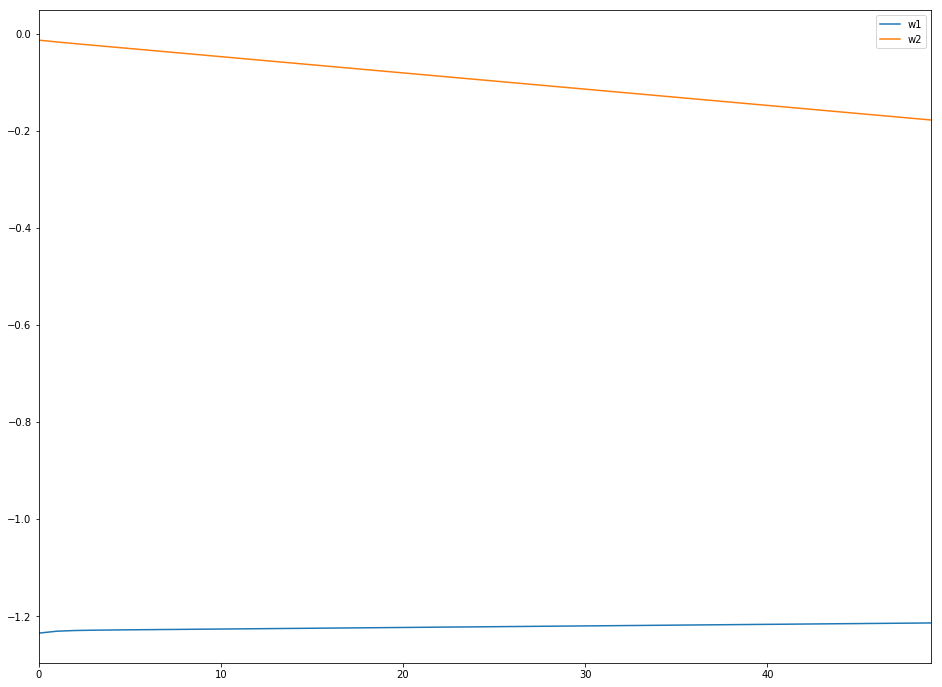

In [49]:
allwgtsDf=pd.DataFrame.from_dict(allwgts, orient='index')
allwgtsDf.columns=['w1', 'w2']
print(allwgtsDf.head())
allwgtsDf.iloc[:,[0,1]].plot()

In [50]:
allwgtsDf.w1.min(), allwgtsDf.w1.max()

(-1.2347260713577271, -1.2136776447296143)

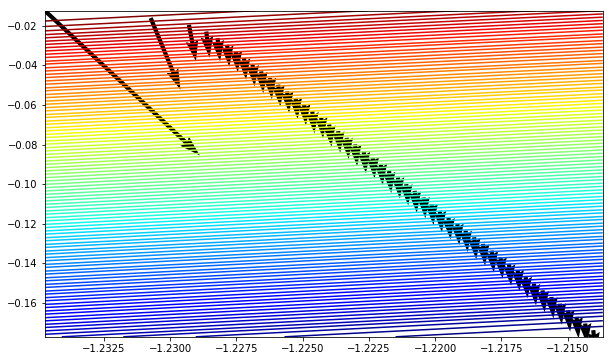

In [51]:
xmin, xmax = allwgtsDf.w1.min(), allwgtsDf.w1.max()
xsteps = (xmax-xmin)/50
ymin, ymax = allwgtsDf.w2.min(), allwgtsDf.w2.max()
ysteps = (ymax-ymin)/50

#xmin, xmax, xstep = 0.0, .05, .001
#ymin, ymax, ystep = 0.0, .05, .001

x, y = np.meshgrid(np.arange(xmin, xmax + xsteps, xsteps), np.arange(ymin, ymax + ysteps, ysteps) )
                                                                   
f= lambda x, y : x**2+y**2 - x*y + x + y
                                                                   
z = f(x, y)
                                                                   
fig, ax = plt.subplots(figsize=(10, 6))

path = allwgtsDf.values.T

ax.contour(x, y, z, levels=np.percentile(z, np.arange(0, 100)), norm=None, cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], 
          scale_units='xy', angles='uv', scale=0.5, color='black')

plt.show()                                                                  


In [52]:
print(model.evaluate(u2, y_train, batch_size=1024))
model.metrics_names

60000/60000 [==============================] - 0s 4us/step
[8.3474193435668944, 0.097366666638851171]


['loss', 'acc']

# 求损失函数曲面

在得到模型以后，可以通过evaluate方法求得给定参数下的损失函数曲面。因此我们可以通过meshgrid方法来获取我们需要考察的两个参数的区间之间的网格，并逐一通过set_weights方法修改模型参数，然后求得相应的损失函数值，从而得到对应meshgrid的损失函数曲面。

**这里需要注意的是**，在画参数求解路径的时候一定要保持原有求解过程的次序。

In [126]:
%%time 

xmin, xmax = allwgtsDf.w1.min(), allwgtsDf.w1.max()
xsteps = (xmax-xmin)/50
ymin, ymax = allwgtsDf.w2.min(), allwgtsDf.w2.max()
ysteps = (ymax-ymin)/50

xmesh, ymesh = np.meshgrid(np.arange(xmin-xsteps, xmax + xsteps, xsteps), np.arange(ymin-ysteps, ymax + ysteps, ysteps) )
z=np.zeros(xmesh.shape)
print(xmin, xmax, ymin, ymax)
weights = model.get_weights()
#print(weights[0])
weights2=weights
model2 = model
for i in range(xmesh.shape[0]):
    for j in range(xmesh.shape[1]):
        weights2[0][0]=xmesh[i,j]
        weights2[0][1]=ymesh[i,j]        
        model2.set_weights(weights2)
        res = model2.evaluate(u2, y_train, verbose=0, batch_size=10240)
        z[i, j]= res[0]
        #print(xmesh[i, j])
    if i % 10 ==0:
        print(i, z[i, j], xmesh[i, j])

-1.23472607136 -1.21367764473 -0.177075341344 -0.0124065866694
0 8.34738126882 -1.21367764473
10 8.34756823985 -1.21367764473
20 8.34775504812 -1.21367764473
30 8.34794169362 -1.21367764473
40 8.34812880452 -1.21367764473
50 8.34831563568 -1.21367764473
Wall time: 1min 9s


In [127]:
import time
#xmesh, ymesh = np.meshgrid(np.arange(xmin-xsteps, xmax + xsteps, xsteps), np.arange(ymin-ysteps, ymax + ysteps, ysteps) )
for i in range(xmesh.shape[0]):
    for j in range(xmesh.shape[1]):
        time.sleep(0.001)
    if i % 10==0:
        print(i, j, xmesh[i, j], ymesh[i, j])

0 51 -1.21367764473 -0.180368716437
10 51 -1.21367764473 -0.147434965502
20 51 -1.21367764473 -0.114501214568
30 51 -1.21367764473 -0.0815674636327
40 51 -1.21367764473 -0.0486337126978
50 51 -1.21367764473 -0.0156999617629


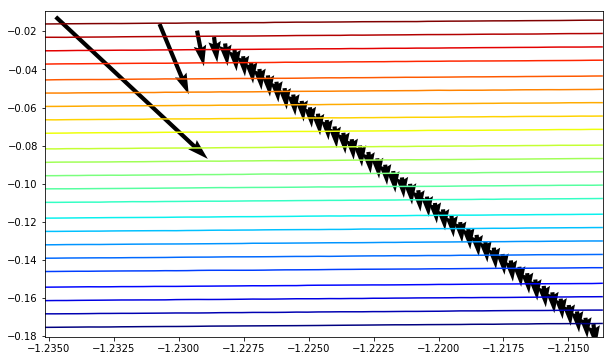

In [128]:
#xmesh, ymesh = np.meshgrid(np.arange(xmin-xsteps, xmax + xsteps, xsteps), np.arange(ymin-ysteps, ymax + ysteps, ysteps) )

                                                         
fig, ax = plt.subplots(figsize=(10, 6))

path = allwgtsDf.values.T

ax.contour(xmesh, ymesh, z, levels=np.percentile(z, np.linspace(0, 100, 25)), norm=None, cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], 
          scale_units='xy', angles='uv', scale=0.5, color='black')
#ax.colorbar()
plt.show()        